# Machine Learning Essentials SS25 - Exercise Sheet 9, Task 2

## Instructions
- `TODO`'s indicate where you need to complete the implementations.
- You may use external resources, but <b>write your own solutions</b>.
- Provide concise, but comprehensible comments to explain what your code does.
- Code that's unnecessarily extensive and/or not well commented will not be scored.

In [3]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import gpytorch

# Import necessary libraries for (3D) plotting, interpolation, and animation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml

from tqdm.notebook import tqdm # pip install tqdm, for progress bars. The notebook version works better in Jupyter notebooks.

import os
# You might want to limit the number of threads used:
os.environ["OMP_NUM_THREADS"] = "10"
os.environ["MKL_NUM_THREADS"] = "10"

# If you have a GPU available, you should move your tensors to the GPU for (much) faster computation:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
torch.manual_seed(42)

Using device: cpu


In [4]:
# Load HTRU2 Dataset
pulsar_data = fetch_openml(data_id=1489, as_frame=True, parser='auto')
X = pulsar_data.data.values
y = pulsar_data.target.values.astype(int)
# Convert targets to binary values (1 for pulsar, 0 for non-pulsar)
y = (y == 1).astype(int)

print(f"Dataset shape: {X.shape}")
print(f"Pulsar count: {y.sum()} ({y.sum()/len(y)*100:.2f}%)")

# Split data into training, validation, and test sets
# We stratify the datasets for a evenly distribution of labels.
# Using 20% for test, 20% for validation, 60% for training
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

# Standardize the features (separately for train, val, and test sets!)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device).view(-1, 1)
X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_t = torch.tensor(y_val, dtype=torch.float32).to(device).view(-1, 1)

# Create Dataset
train_dataset = TensorDataset(X_train_t, y_train_t)

Dataset shape: (5404, 5)
Pulsar count: 3818 (70.65%)


In [5]:
# MLP Model - we'll use a very simple 1 hidden layer architecture
class MLP(nn.Module):
    def __init__(self, input_size, n_hidden_units):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_size, n_hidden_units) # Hidden layer size is n_hidden_units
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(n_hidden_units, 1)

    def forward(self, x):
        return self.layer2(self.relu(self.layer1(x)))

def objective_function(learning_rate, batch_size):
    # TODO: Implement the objective function - this is our "expensive" black-box function that we want to optimize.
    # Here, the objective function trains an MLP with given hyperparameters and returns the validation accuracy.

    n_hidden_units = 16 # Fixed number of hidden units for this exercise (this could be another hyperparameter to optimize, but we want a 2D search space here)

    batch_size = int(round(batch_size))  # Ensure batch size is an integer

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Create DataLoader with specified batch size

    # 1. Initialize the MLP model with the given `n_hidden_units`.
    # Don't forget to move the model to the correct `device`.
    # 2. Define the loss function (e.g. BCEWithLogitsLoss for classification) and the optimizer (e.g. Adam), which should use the given `learning_rate`.
    # 3. Implement the training loop for a fixed number of epochs (e.g., 20-30). Remember, for the purposes of this exercise, we only need some performance signal, not necessarily a fully converged model.

    model = MLP(input_size=X_train.shape[1], n_hidden_units=n_hidden_units).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    num_epochs = 20
    model.train()

    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            # Standard Torch training: zero_grad, forward pass, loss, backward, step
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluate the model on the validation set
    model.eval()
    with torch.no_grad():
         val_outputs = model(X_val_t)
         val_preds = (torch.sigmoid(val_outputs) > 0.5).float() # Remember to apply the sigmoid to our output logits to get a "classifier output". We can choose a 0.5 threshold (this is not optimal however since our data is highly imbalanced. However, for this exercise it is sufficient)
         accuracy = (val_preds == y_val_t).float().mean().item()

    return accuracy # Return validation accuracy

Grid Search Evaluations:   0%|          | 0/100 [00:00<?, ?it/s]

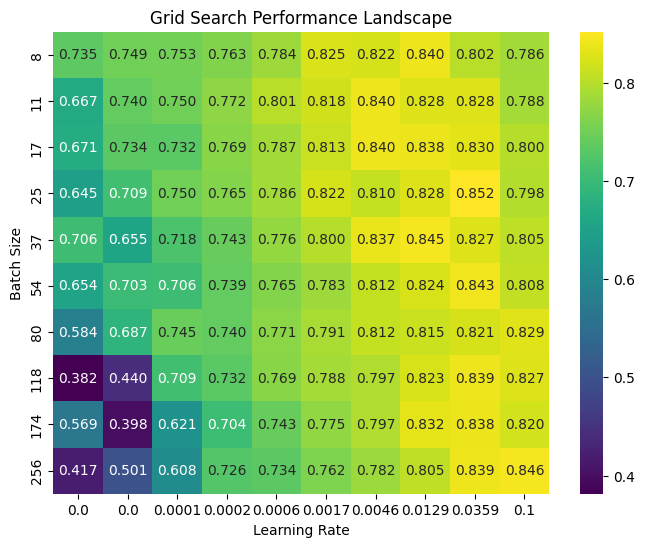

In [6]:
# Define search grid for hyperparameters - you might want to do the testing using a smaller grid (or use a smaller grid in general), especially if you're on a cpu.
lr_space_grid = np.logspace(-5, -1, 10) # 10^-5 to 10^-1
batch_size_space_grid = np.logspace(3, 8, 10, base=2).astype(int) # 2^3 to 2^8

# Run the grid search
total_evaluations = len(lr_space_grid) * len(batch_size_space_grid)
grid_results = np.zeros((len(lr_space_grid), len(batch_size_space_grid)))
start_time_grid = time.time()

with tqdm(total=total_evaluations, desc="Grid Search Evaluations") as pbar:
            # TODO: Implement a nested loop to iterate over `lr_space_grid` and `n_hidden_units_grid`.
            # 1. In the inner loop, call the objective function for each value on the grid.
            # 2. Store the returned accuracy in the `grid_results` array.
            # 3. Update the progress bar with `pbar.update(1)`.
    for i, lr in enumerate(lr_space_grid):
        for j, batch_size in enumerate(batch_size_space_grid):
            acc = objective_function(lr, batch_size)
            grid_results[i, j] = acc
            pbar.update(1)

end_time_grid = time.time()

grid_search_time = end_time_grid - start_time_grid # Store the time it took to run grid search

# Visualize results
plt.figure(figsize=(8, 6))
sns.heatmap(grid_results.T, xticklabels=np.round(lr_space_grid, 4), yticklabels=batch_size_space_grid, annot=True, fmt=".3f", cmap="viridis")
plt.xlabel("Learning Rate")
plt.ylabel("Batch Size")
plt.title("Grid Search Performance Landscape")
plt.show()

In [7]:
# GP surrogate model
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        # We'll use a Matérn kernel with nu=2.5, which is a often a good first guess for many problems.
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# UCB Acquisition Function
def upper_confidence_bound(model, x, kappa=1):
    """Calculates UCB for a given set of candidate points x."""
    model.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var(): # again fast_pred_var for speeding up predictions (c.f. Task 1.3)
        posterior = model.likelihood(model(x))
        mean = posterior.mean
        std = torch.sqrt(posterior.variance)
        return mean + kappa * std

# BO Start
print("Running Bayesian Optimization...")

# Define search space for BO (needs to correspond to your chosen grid)
lr_bounds = (-5, -1) # Log10 scale for learning rate
batch_size_bounds = (3, 8) # Log2 scale for batch size

# Initial random samples
n_initial = 5
train_x_bo_norm = torch.rand(n_initial, 2, dtype=torch.float32)
train_y_bo = torch.zeros(n_initial, dtype=torch.float32)

# History for plotting
bo_points = []

# Main BO loop
n_iterations = 15 # Total budget = 5 (initial) + 10 = 20, adjust as you see fit
total_bo_evaluations = n_initial + n_iterations
kappa = ... # Fixed kappa - Higher value encourages more exploration TODO: Set appropriate kappe value

start_time_bo = time.time()
with tqdm(total=total_bo_evaluations, desc="Bayesian Optimization Evaluations") as pbar:
    # Make initial random evaluations to get the first data points for the GP
    for i in range(n_initial):
        lr = 10**(train_x_bo_norm[i, 0].item() * (lr_bounds[1] - lr_bounds[0]) + lr_bounds[0]) # convert log10 to actual learning rate
        batch_size_log2 = train_x_bo_norm[i, 1].item() * (batch_size_bounds[1] - batch_size_bounds[0]) + batch_size_bounds[0]
        batch_size = 2**int(batch_size_log2)  # Convert log2 to actual batch size

        train_y_bo[i] = objective_function(lr, batch_size)
        bo_points.append([lr, batch_size])
        pbar.update(1)  # Update progress bar

    # Initialize the GP model using the initial random samples
    likelihood_bo = gpytorch.likelihoods.GaussianLikelihood()
    model_bo = GPRegressionModel(train_x_bo_norm, train_y_bo, likelihood_bo)
    model_bo.set_train_data(train_x_bo_norm, train_y_bo, strict=False) # Update the model with initial data

    # Main BO iterations
    for i in range(n_iterations):
        model_bo.train()
        likelihood_bo.train()
        optimizer_bo = torch.optim.Adam(model_bo.parameters(), lr=0.1)
        mll_bo = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_bo, model_bo)

        for _ in range(50):
            # TODO: Fit the GP surrogate model to the data observed so far. Optimize the GP's own hyperparameters via max marginal likelihood
            # 1. Zero the gradients
            # 2. Get output from model
            # 3. Calculate the loss (= negative MLL)
            # 4. Backpropagate the loss, perform optimizer step

            optimizer_bo.zero_grad()
            output = model_bo(train_x_bo_norm)
            loss = -mll_bo(output, train_y_bo)
            loss.backward()
            optimizer_bo.step()

        # 2. Maximize the UCB acquisition function to find the next point to evaluate.
        # Here, we'll use the simplest approach: uniformly sampling random candidates and evaluating them, and then chosing the best one. More sophisticated models would use e.g. gradient ascent.
        kappa = 2.0
        n_candidates = 500
        candidate_x = torch.rand(n_candidates, 2, dtype=torch.float32)
        ucb_values = upper_confidence_bound(model_bo, candidate_x, kappa=kappa) # Compute UCB for the candidate points

        # Select the next point to evaluate, according to the UCB acquisition function
        best_candidate_idx = torch.argmax(ucb_values)
        next_x_norm = candidate_x[best_candidate_idx].view(1, -1) #  Normalize the next point to [0, 1] for the GP model
        lr = 10**(next_x_norm[0, 0].item() * (lr_bounds[1] - lr_bounds[0]) + lr_bounds[0])
        batch_size_log2 = next_x_norm[0, 1].item() * (batch_size_bounds[1] - batch_size_bounds[0]) + batch_size_bounds[0]
        batch_size = 2**int(batch_size_log2)

        # 3. TODO: Call the "expensive objective function" at the selected point
        next_y = torch.tensor(objective_function(lr, batch_size), dtype=torch.float32)
        bo_points.append([lr, batch_size])

        # 4. TODO: Augment the dataset with the new observation.
        # Use torch.cat to add `next_x_norm` and `next_y` to your training data.
        train_x_bo_norm = torch.cat([train_x_bo_norm, next_x_norm], dim=0)
        train_y_bo = torch.cat([train_y_bo, next_y.view(1)], dim=0)
        model_bo.set_train_data(train_x_bo_norm, train_y_bo, strict=False)  # Update the model with the new data
        pbar.update(1)  # Update progress bar
end_time_bo = time.time()


bo_time = end_time_bo - start_time_bo  # Store the time it took to run Bayesian Optimization
bo_points = np.array(bo_points) # Store the BO points as a numpy array for easier plotting later

Running Bayesian Optimization...


Bayesian Optimization Evaluations:   0%|          | 0/20 [00:00<?, ?it/s]

In [8]:
# This Code should produce a 3D animated plot of the BO process, showing the path taken by the optimization algorithm in the hyperparameter space.

# Data from grid search
log_lr_space = np.log10(lr_space_grid)
log_batch_size_space = np.log2(batch_size_space_grid)
X_grid, Y_grid = np.meshgrid(log_lr_space, log_batch_size_space)
points = np.array([X_grid.flatten(), Y_grid.flatten()]).T
values = grid_results.T.flatten()

# Get fine grid for plotting --> interpolate the grid results to a finer grid for smooth plot
log_lr_fine = np.linspace(log_lr_space.min(), log_lr_space.max(), 100)
log_batch_size_fine = np.linspace(log_batch_size_space.min(), log_batch_size_space.max(), 100)
X_fine, Y_fine = np.meshgrid(log_lr_fine, log_batch_size_fine)
Z_fine = griddata(points, values, (X_fine, Y_fine), method='cubic')
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the static surface
surf = ax.plot_surface(X_fine, Y_fine, Z_fine, cmap='plasma', alpha=0.8, rstride=5, cstride=5, linewidth=0.1)

# Data from BO
bo_lrs_log = np.log10(bo_points[:, 0])
bo_batch_sizes_log = np.log2(bo_points[:, 1])
bo_surface_accs = griddata(points, values, (bo_lrs_log, bo_batch_sizes_log), method='cubic')

# Initialize empty plot elements for the animation
path_line, = ax.plot([], [], [], 'r-', linewidth=2.5, zorder=10)
path_points = ax.scatter([], [], [], c='red', s=50, zorder=10)
initial_points = ax.scatter([], [], [], c='black', s=70, label='Initial Samples (i.e. GP Data)', zorder=10)
best_point_marker = ax.scatter([], [], [], c='lime', s=300, marker='*', zorder=12, ec='black', label='Best Point So Far')
text_labels = [ax.text(0, 0, 0, '', color='green', fontsize=12, weight='bold', zorder=11, ha='center') for _ in range(len(bo_points))]

# Plot format
ax.set_title('Animated BO Process', fontsize=18)
ax.set_xlabel('Log10(Learning Rate)', fontsize=12)
ax.set_ylabel('Log2(Batch Size)', fontsize=12)
ax.set_zlabel('Val. Accuracy', fontsize=12)
ax.view_init(elev=15, azim=125)
fig.colorbar(surf, shrink=0.6, aspect=10, label=' Val. Accuracy')

# Animation update function --> iterating through frames
def update(frame):
    i = frame + 1
    # Update path line and points
    path_line.set_data(bo_lrs_log[:i], bo_batch_sizes_log[:i])
    path_line.set_3d_properties(bo_surface_accs[:i])

    # Differentiate initial points from BO-chosen points
    initial_mask = np.arange(i) < n_initial
    bo_mask = ~initial_mask
    initial_points._offsets3d = (bo_lrs_log[:i][initial_mask], bo_batch_sizes_log[:i][initial_mask], bo_surface_accs[:i][initial_mask])
    path_points._offsets3d = (bo_lrs_log[:i][bo_mask], bo_batch_sizes_log[:i][bo_mask], bo_surface_accs[:i][bo_mask])

    # Update numbered labels
    for j in range(i):
        text_labels[j].set_position((bo_lrs_log[j], bo_batch_sizes_log[j]))
        text_labels[j].set_3d_properties(bo_surface_accs[j] + 0.005)
        text_labels[j].set_text(f'{j+1}')
    for j in range(i, len(bo_points)):
        text_labels[j].set_text('') # Hide future labels

    # Update best point marker
    current_best_idx = torch.argmax(train_y_bo[:i]).item()
    best_point_marker._offsets3d = ([bo_lrs_log[current_best_idx]], [bo_batch_sizes_log[current_best_idx]], [bo_surface_accs[current_best_idx]])

    ax.legend(loc='upper left')
    return path_line, path_points, initial_points, best_point_marker, *text_labels

# Create and display the animation
ani = FuncAnimation(fig, update, frames=len(bo_points), interval=500, blit=False)
plt.close(fig) # Prevent static plot from showing
HTML(ani.to_html5_video())

In [9]:
# This code should output the results of grid search vs. BO
best_grid_idx = np.unravel_index(np.argmax(grid_results), grid_results.shape)
best_grid_params = (lr_space_grid[best_grid_idx[0]], batch_size_space_grid[best_grid_idx[1]])
best_grid_acc = np.max(grid_results)

best_bo_idx = torch.argmax(train_y_bo).item()
best_bo_params_norm = train_x_bo_norm[best_bo_idx]
best_bo_lr = 10**(best_bo_params_norm[0].item() * (lr_bounds[1] - lr_bounds[0]) + lr_bounds[0])
best_bo_batch_size_log2 = best_bo_params_norm[1].item() * (batch_size_bounds[1] - batch_size_bounds[0]) + batch_size_bounds[0]
best_bo_batch_size = 2**best_bo_batch_size_log2
best_bo_acc = train_y_bo[best_bo_idx].item()

# Results output
print("Results Summary:")
print(f"Grid Search ({total_evaluations} evaluations):")
print(f"  - Time Taken:    {grid_search_time:.2f} seconds")
print(f"  - Best Accuracy: {best_grid_acc:.4f}")
print(f"  - Best Params:   lr={best_grid_params[0]:.5f}, batch_size={best_grid_params[1]}")
print("\n")
print(f"Bayesian Optimization ({total_bo_evaluations} evaluations):")
print(f"  - Time Taken:    {bo_time:.2f} seconds")
print(f"  - Best Accuracy: {best_bo_acc:.4f}")
print(f"  - Best Params:   lr={best_bo_lr:.5f}, batch_size={int(round(best_bo_batch_size))}")

Results Summary:
Grid Search (100 evaluations):
  - Time Taken:    432.86 seconds
  - Best Accuracy: 0.8520
  - Best Params:   lr=0.03594, batch_size=25


Bayesian Optimization (20 evaluations):
  - Time Taken:    129.55 seconds
  - Best Accuracy: 0.8532
  - Best Params:   lr=0.01985, batch_size=83


**TODO** Assess your results:
- Based on the animation, describe the behavior of the Bayesian Optimization agent. (How) does it balance exploration and exploitation?
- Compare the efficiency and final performance of Grid Search vs. Bayesian Optimization. Which method would you prefer for a more complex problem, and why?

At the start, the BO agent randomly samples 5 initial points from the hyperparameter space. This phase is pure exploration to initialize the Gaussian Process (GP) model.

As the optimization proceeds:

The agent starts to concentrate evaluations in regions where validation accuracy is high, indicating exploitation of known good areas.

However, it still occasionally tries out less-explored regions, especially where the GP model predicts high uncertainty. This reflects exploration.

This balance is governed by the Upper Confidence Bound (UCB) acquisition function:

                                      𝛼UCB(𝑥)=𝜇GP(𝑥)+𝜅⋅𝜎GP(𝑥)

where,                                                                                                                                       
    - μGP(x) encourages exploitation by favoring high predicted performance.                                                                 
    - 𝜎GP(𝑥) encourages exploration by favoring uncertain regions.                                                                           
    - A higher κ (e.g., 2.0) gives more weight to exploration.                                                                               

In our case, the BO agent demonstrates this tradeoff well — starting broad, then intelligently narrowing down to high-performing hyperparameter combinations.

| **Aspect**         | **Grid Search**                                     | **Bayesian Optimization**                        |
| ------------------ | --------------------------------------------------- | ------------------------------------------------ |
| **Evaluations**    | Tries out all combinations in the grid              | Chooses points smartly using a model             |
| **Efficiency**     | Not very efficient — can waste time on bad settings | Much more efficient — focuses on promising areas |
| **Final Accuracy** | Often good, but might take longer to get there      | Usually reaches good results faster              |
| **Scalability**    | Struggles with many hyperparameters                 | Handles more complex spaces better               |
| **Time Taken**     | Can be quite slow                                   | Faster (fewer evaluations needed)                |

Bayesian Optimization is a better choice when:

Each training run takes a long time (e.g., deep learning)

You're working with a lot of hyperparameters

You want to find good results quickly without testing every single combination